# Backpropagation

7 x 6 x 5 x 2 의 4계층 신경망 구조를 작성하여 오차 역전파로 학습이 잘 진행되고, 편미분이 수치 미분의 결과와 동일한지 검증한다.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd

import sys
sys.path.append('/Users/kaonpark/workspace/github.com/likejazz/kaon-learn')
import kaonlearn
from kaonlearn.plots import plot_decision_regions, plot_history

def init():
    global i, w_1, b_1, w_2, b_2, w_3, b_3, t
    global delta_w_1_5_history, w_1_5_history, delta_w_1_6_history, w_1_6_history, delta_b_1_history, b_1_history
        
    i = np.array([0.4,-0.2,0.1,0.1,-0.15,0.6,-0.9]).reshape(-1, 1)

    np.random.seed(12)
    w_1 = np.random.rand(6, 7)
    b_1 = np.random.rand(6).reshape(-1, 1)
    w_2 = np.random.rand(5, 6)
    b_2 = np.random.rand(5).reshape(-1, 1)
    w_3 = np.random.rand(2, 5)
    b_3 = np.random.rand(2).reshape(-1, 1)
    
    t = np.array([[0.87503811],[0.83690408]])
    
    delta_w_1_5_history = []
    w_1_5_history = []
    delta_w_1_6_history = []
    w_1_6_history = []
    delta_b_1_history = []
    b_1_history = []

In [2]:
def sigmoid(z: np.ndarray):
    return 1 / (1 + np.exp(-z))

def d_sigmoid(z: np.ndarray):
    return sigmoid(z) * (1.0 - sigmoid(z))

def gradient_check(analytic, numeric):
    numerator = abs(analytic-numeric)
    denominator = max(analytic,numeric)
    difference = numerator/denominator
    
    if difference < 1e-3: # cs231n의 권장 수치는 1e-7인데 여기서는 좀 더 높인다.
        print ("The gradient is correct!")
    else:
        print ("The gradient is wrong!")

In [3]:
def forward(i):
    global w_1, b_1, w_2, b_2, w_3, b_3
    
    net_h1 = np.dot(w_1, i) + b_1
    out_h1 = sigmoid(net_h1)
    
    net_h2 = np.dot(w_2, out_h1) + b_2
    out_h2 = sigmoid(net_h2)
    
    net_o = np.dot(w_3, out_h2) + b_3
    out_o = sigmoid(net_o)
    # 최종 출력 레이어에 activation(sigmoid)이 없는 형태는 아래와 같다.
    # out_o = net_o
    
    return net_h1, out_h1, net_h2, out_h2, net_o, out_o

In [4]:
def train(i, t):
    lr = 0.1
    
    global w_1, b_1, w_2, b_2, w_3, b_3
    global delta_w_1, delta_b_1, delta_w_2, delta_b_2, delta_w_3, delta_b_3
    
    net_h1, out_h1, net_h2, out_h2, net_o, out_o = forward(i)

    # backpropagation!
    d_o_errors = - (t - out_o)
    delta_w_3 = np.dot(d_o_errors * d_sigmoid(net_o), out_h2.T)
    # 최종 출력 레이어에 activation(sigmoid)이 없다면 d_sigmoid가 생략된다.
    # delta_w_3 = np.dot(d_o_errors, out_h2.T)
    w_3 += - lr * delta_w_3
    delta_b_3 = d_o_errors * d_sigmoid(net_o)
    # 최종 출력 레이어에 activation(sigmoid)이 없다면 d_sigmoid가 생략된다.
    # delta_b_3 = d_o_errors
    b_3 += - lr * delta_b_3

    d_h2_errors = np.dot(w_3.T, d_o_errors * d_sigmoid(net_o))
    # 최종 출력 레이어에 activation(sigmoid)이 없다면 d_sigmoid가 생략된다.
    # d_h2_errors = np.dot(w_3.T, d_o_errors)
    delta_w_2 = np.dot(d_h2_errors * d_sigmoid(net_h2), out_h1.T)
    w_2 += - lr * delta_w_2
    delta_b_2 = d_h2_errors * d_sigmoid(net_h2)
    b_2 += - lr * delta_b_2

    d_h1_errors = np.dot(w_2.T, d_h2_errors * d_sigmoid(net_h2))
    delta_w_1 = np.dot(d_h1_errors * d_sigmoid(net_h1), i.T)
    w_1 += - lr * delta_w_1
    delta_b_1 = d_h1_errors * d_sigmoid(net_h1)
    b_1 += - lr * delta_b_1
    
    # for visualization
    global delta_w_1_5_history, w_1_5_history, delta_w_1_6_history, w_1_6_history, delta_b_1_history, b_1_history
    delta_w_1_5_history.append(delta_w_1[0][5])
    w_1_5_history.append(w_1[0][5])
    delta_w_1_6_history.append(delta_w_1[0][6])
    w_1_6_history.append(w_1[0][6])
    delta_b_1_history.append(delta_b_1[0][0])
    b_1_history.append(b_1[0][0])

def query(i, t):
    _, _, _, _, _, out_o = forward(i)

    # E 출력
    print(t - out_o)

In [5]:
# Gradient Checking(w_3, b_3)
init()
train(i,t)
h = 1e-7

init()
for k in range(2):
    for j in range(5):
        # 수치 미분(numerical gradient) 진행
        init()
        w_3[k][j] += h
        _, _, _, _, _, out_o = forward(i)
        e1 = np.sum((t - out_o) ** 2) / 2

        init()
        w_3[k][j] -= h
        _, _, _, _, _, out_o = forward(i)
        e2 = np.sum((t - out_o) ** 2) / 2

        # 수치 미분 결과가 해석적 미분(analytic gradient)과 동일한지 검증
        numeric_delta_w_3 = (e1 - e2) / (2 * h)
        print("%.16f, %.16f" % (delta_w_3[k][j], numeric_delta_w_3))
        gradient_check(delta_w_3[k][j], numeric_delta_w_3)

    init()
    b_3[k] += h
    _, _, _, _, _, out_o = forward(i)
    e1 = np.sum((t - out_o) ** 2) / 2

    init()
    b_3[k] -= h
    _, _, _, _, _, out_o = forward(i)
    e2 = np.sum((t - out_o) ** 2) / 2

    # 수치 미분 결과가 해석적 미분(analytic gradient)과 동일한지 검증
    numeric_delta_b_3 = (e1 - e2) / (2 * h)
    print()
    print("%.16f, %.16f" % (delta_b_3[k], numeric_delta_b_3))
    gradient_check(delta_b_3[k], numeric_delta_b_3)
    print()

0.0020884340416671, 0.0020884341131455
The gradient is correct!
0.0022944925136705, 0.0022944925213292
The gradient is correct!
0.0025359120035654, 0.0025359120098961
The gradient is correct!
0.0026220925711652, 0.0026220924823767
The gradient is correct!
0.0026127957312623, 0.0026127957436506
The gradient is correct!

0.0028046163835497, 0.0028046163915579
The gradient is correct!

0.0032742240271800, 0.0032742239128303
The gradient is correct!
0.0035972802437407, 0.0035972802341078
The gradient is correct!
0.0039757750770333, 0.0039757750390501
The gradient is correct!
0.0041108880274456, 0.0041108880362295
The gradient is correct!
0.0040963125436239, 0.0040963125079452
The gradient is correct!

0.0043970468623039, 0.0043970468238674
The gradient is correct!



In [6]:
# Gradient Checking(w_1, b_1)
init()
train(i,t)
h = 1e-7

init()
for k in range(6):
    for j in range(7):
        # 수치 미분(numerical gradient) 진행
        init()
        w_1[k][j] += h
        _, _, _, _, _, out_o = forward(i)
        e1 = np.sum((t - out_o) ** 2) / 2

        init()
        w_1[k][j] -= h
        _, _, _, _, _, out_o = forward(i)
        e2 = np.sum((t - out_o) ** 2) / 2

        # 수치 미분 결과가 해석적 미분(analytic gradient)과 동일한지 검증
        numeric_delta_w_1 = (e1 - e2) / (2 * h)
        print("%.16f, %.16f" % (delta_w_1[k][j], numeric_delta_w_1))
        gradient_check(delta_w_1[k][j], numeric_delta_w_1)

    init()
    b_1[k] += h
    _, _, _, _, _, out_o = forward(i)
    e1 = np.sum((t - out_o) ** 2) / 2

    init()
    b_1[k] -= h
    _, _, _, _, _, out_o = forward(i)
    e2 = np.sum((t - out_o) ** 2) / 2

    # 수치 미분 결과가 해석적 미분(analytic gradient)과 동일한지 검증
    numeric_delta_b_1 = (e1 - e2) / (2 * h)
    print()
    print("%.16f, %.16f" % (delta_b_1[k], numeric_delta_b_1))
    gradient_check(delta_b_1[k], numeric_delta_b_1)
    print()

0.0000974372978874, 0.0000974974961876
The gradient is correct!
-0.0000487186489437, -0.0000487487654410
The gradient is correct!
0.0000243593244718, 0.0000243742439426
The gradient is correct!
0.0000243593244718, 0.0000243742439426
The gradient is correct!
-0.0000365389867078, -0.0000365616738274
The gradient is correct!
0.0001461559468311, 0.0001462461922397
The gradient is correct!
-0.0002192339202466, -0.0002193693057068
The gradient is correct!

0.0002435932447185, 0.0002437437317954
The gradient is correct!

0.0000913394440743, 0.0000913891792104
The gradient is correct!
-0.0000456697220372, -0.0000456946720045
The gradient is correct!
0.0000228348610186, 0.0000228473663599
The gradient is correct!
0.0000228348610186, 0.0000228473663599
The gradient is correct!
-0.0000342522915279, -0.0000342708066786
The gradient is correct!
0.0001370091661115, 0.0001370838078468
The gradient is correct!
-0.0002055137491673, -0.0002056257334543
The gradient is correct!

0.0002283486101858, 0.000

In [7]:
# 실제 학습이 잘 되는지 확인
init()
for _ in range(3000): 
    train(i,t)
query(i,t)

[[-0.00000015]
 [ 0.        ]]


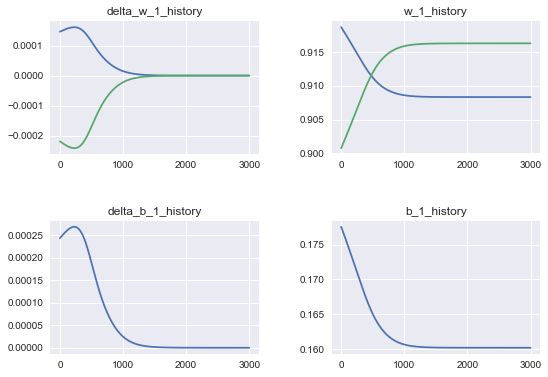

In [8]:
# plot with various axes scales
plt.figure(1)

plt.subplot(221)
plt.plot(delta_w_1_5_history)
plt.title("delta_w_1_history")

plt.subplot(222)
plt.plot(w_1_5_history)
plt.title("w_1_history")

plt.subplot(221)
plt.plot(delta_w_1_6_history)

plt.subplot(222)
plt.plot(w_1_6_history)

plt.subplot(223)
plt.plot(delta_b_1_history)
plt.title("delta_b_1_history")

plt.subplot(224)
plt.plot(b_1_history)
plt.title("b_1_history")

# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
# https://matplotlib.org/gallery/pyplots/pyplot_scales.html#sphx-glr-gallery-pyplots-pyplot-scales-py
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.show()

w_1의 기울기가 0에 이르는 지점이 bias 학습이 함께 진행될때는 1,200 epoch 정도이나,  
bias 학습을 하지 않으면 1,500 epoch 이상을 넘어선다.

In [9]:
w_1

array([[ 0.14722202,  0.74352011,  0.26157981,  0.53200419,  0.01717777,
         0.90833578,  0.91633169],
       [ 0.02672103,  0.96029954,  0.13553422,  0.28215325,  0.60859583,
         0.93417454,  0.86781144],
       [-0.00033641,  0.52252385,  0.55138872,  0.4847285 ,  0.76910752,
         0.15682329,  0.77040064],
       [ 0.01250873,  0.13936071,  0.11419775,  0.30782232,  0.67456555,
         0.45877818,  0.8348457 ],
       [ 0.28253518,  0.73665178,  0.70085945,  0.32580658,  0.33729188,
         0.96748067,  0.64044822],
       [ 0.94588999,  0.76968742,  0.82390337,  0.40553442,  0.45296724,
         0.39399632,  1.00509112]])

# 미분 계산

In [10]:
import sympy
sympy.init_printing(use_latex='mathjax')
w11, x1, w12, x2, w13, x3, b3 = sympy.symbols('w11 x1 w12 x2 w13 x3 b3')
z = w11 * x1 + w12 * x2 + w13 * x3 + b3
z

b₃ + w₁₁⋅x₁ + w₁₂⋅x₂ + w₁₃⋅x₃

In [11]:
sympy.Derivative(z, b3).doit()

1